In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# 예제 데이터 생성 (10년치 일일 데이터: 환경 변수와 가격)
np.random.seed(42)
df_1=pd.read_csv('/content/sample_data/감자_상품_100g_일별소매가.csv',encoding='cp949')
df_1=df_1[['구분','유통업체']]
df_1['구분']=pd.to_datetime(df_1['구분'], format='%Y-%m-%d')
df=pd.read_excel('/content/sample_data/데이터 합.xlsx')
df=df.rename(columns={'분류':'구분'})

df['sin_month'] = np.sin(2 * np.pi * df['구분'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['구분'].dt.month / 12)

# 일 데이터를 원형으로 변환
df['day_of_year'] = df['구분'].dt.dayofyear
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

df=pd.merge(df,df_1,left_on='구분',right_on='구분',how='left')
df=df.drop(columns='구분')
# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 입력(X)과 출력(y) 생성
sequence_length = 365  # 지난 sequence_length일 데이터로 다음날 가격 예측
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length, :-1])  # 환경 변수
    y.append(scaled_data[i + sequence_length, -1])    # 농산물 가격

X = np.array(X)
y = np.array(y)


In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 데이터 분할 (80% 학습, 20% 테스트)
split = int(len(X) * 0.8)
train_dataset = TimeSeriesDataset(X[:split], y[:split])
test_dataset = TimeSeriesDataset(X[split:], y[split:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True  # Ensure batch is the first dimension
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        x = self.encoder(x)    # [batch_size, seq_len, embed_dim]
        x = x[:, -1, :]        # Use the last sequence output
        return self.fc(x)      # [batch_size, output_dim]


Epoch 1/20, Loss: 0.0579
Epoch 2/20, Loss: 0.0192
Epoch 3/20, Loss: 0.0165
Epoch 4/20, Loss: 0.0133
Epoch 5/20, Loss: 0.0126
Epoch 6/20, Loss: 0.0102
Epoch 7/20, Loss: 0.0114
Epoch 8/20, Loss: 0.0075
Epoch 9/20, Loss: 0.0071
Epoch 10/20, Loss: 0.0064
Epoch 11/20, Loss: 0.0063
Epoch 12/20, Loss: 0.0053
Epoch 13/20, Loss: 0.0052
Epoch 14/20, Loss: 0.0039
Epoch 15/20, Loss: 0.0044
Epoch 16/20, Loss: 0.0040
Epoch 17/20, Loss: 0.0038
Epoch 18/20, Loss: 0.0035
Epoch 19/20, Loss: 0.0034
Epoch 20/20, Loss: 0.0034


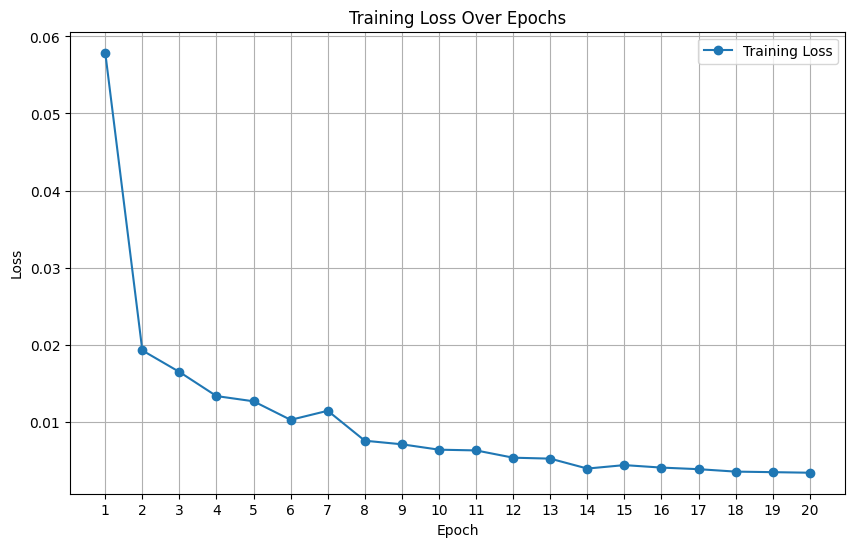

In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
input_dim = 29         # 환경 변수
embed_dim = 64        # 임베딩 차원
num_heads = 4         # 멀티헤드 수
ff_dim = 128          # 피드포워드 네트워크 차원
num_layers = 2        # Transformer 레이어 수
output_dim = 1        # 예측 값 (가격)
epoch_losses=[]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        plt_loss=train_loss / len(train_loader)

    avg_loss = train_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(epoch_losses) + 1))
plt.grid(True)
plt.legend()
plt.show()


In [5]:
# 테스트
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.0305
